## Linear Regression

## Question
What impacts the Charges of insurance

## Prediction
I think Age, BMI and wether or not your a smoker, these features say something about your health and if your health is bad you have more risk to a serverer sickness or injury

## Read CSV and Import Librarys

In [195]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error


df = pd.read_csv('insurance.csv')

## One hot encode

In [196]:
# One-hot encoding 'smoker', 'sex', and 'region'
df_encoded = pd.get_dummies(df, columns=['smoker', 'sex', 'region'])

# Print the first few rows of the encoded DataFrame
print(df_encoded.head())


   age     bmi  children      charges  smoker_no  smoker_yes  sex_female  \
0   19  27.900         0  16884.92400      False        True        True   
1   18  33.770         1   1725.55230       True       False       False   
2   28  33.000         3   4449.46200       True       False       False   
3   33  22.705         0  21984.47061       True       False       False   
4   32  28.880         0   3866.85520       True       False       False   

   sex_male  region_northeast  region_northwest  region_southeast  \
0     False             False             False             False   
1      True             False             False              True   
2      True             False             False              True   
3      True             False              True             False   
4      True             False              True             False   

   region_southwest  
0              True  
1             False  
2             False  
3             False  
4             Fals

charges             1.000000
smoker_yes          0.787251
age                 0.299008
bmi                 0.198341
region_southeast    0.073982
children            0.067998
sex_male            0.057292
region_northeast    0.006349
region_northwest   -0.039905
region_southwest   -0.043210
sex_female         -0.057292
smoker_no          -0.787251
Name: charges, dtype: float64


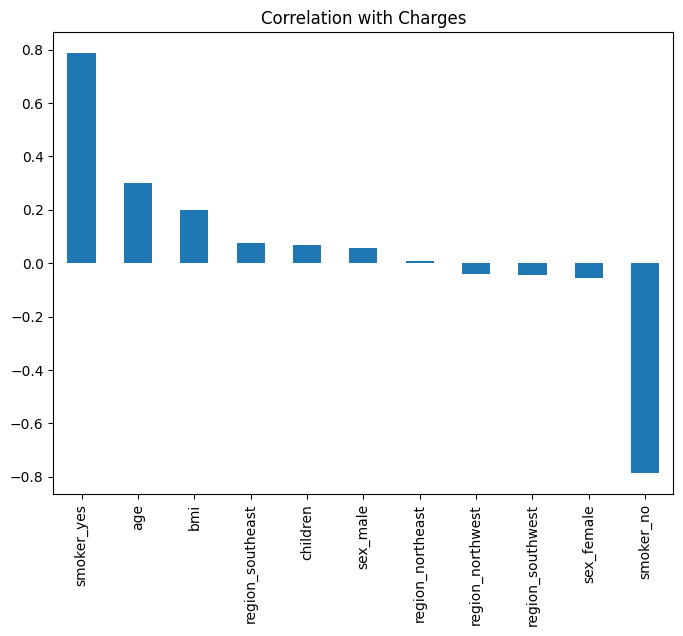

In [197]:
# Calculate the correlations with 'charges'
corr_charges = df_encoded.corr()['charges'].sort_values(ascending=False)

# Print the correlations
print(corr_charges)

plt.figure(figsize=(8,6))
corr_charges.drop('charges').plot(kind='bar')
plt.title('Correlation with Charges')
plt.show()


## Select only the necessery collums

In [198]:
dfFiltered = df_encoded[['age', 'bmi', 'smoker_yes', 'charges']]
dfFiltered.head(5)

,age,bmi,smoker_yes,charges
0,19,27.900,True,16884.92400
1,18,33.770,False,1725.55230
2,28,33.000,False,4449.46200
3,33,22.705,False,21984.47061
4,32,28.880,False,3866.85520


## Clean Dataset and Remove Outliers

In [199]:
df_cleaned = dfFiltered.dropna()
print(df_cleaned.isna().sum())

age           0
bmi           0
smoker_yes    0
charges       0
dtype: int64


##### Plotting boxplots to see if there are outliers

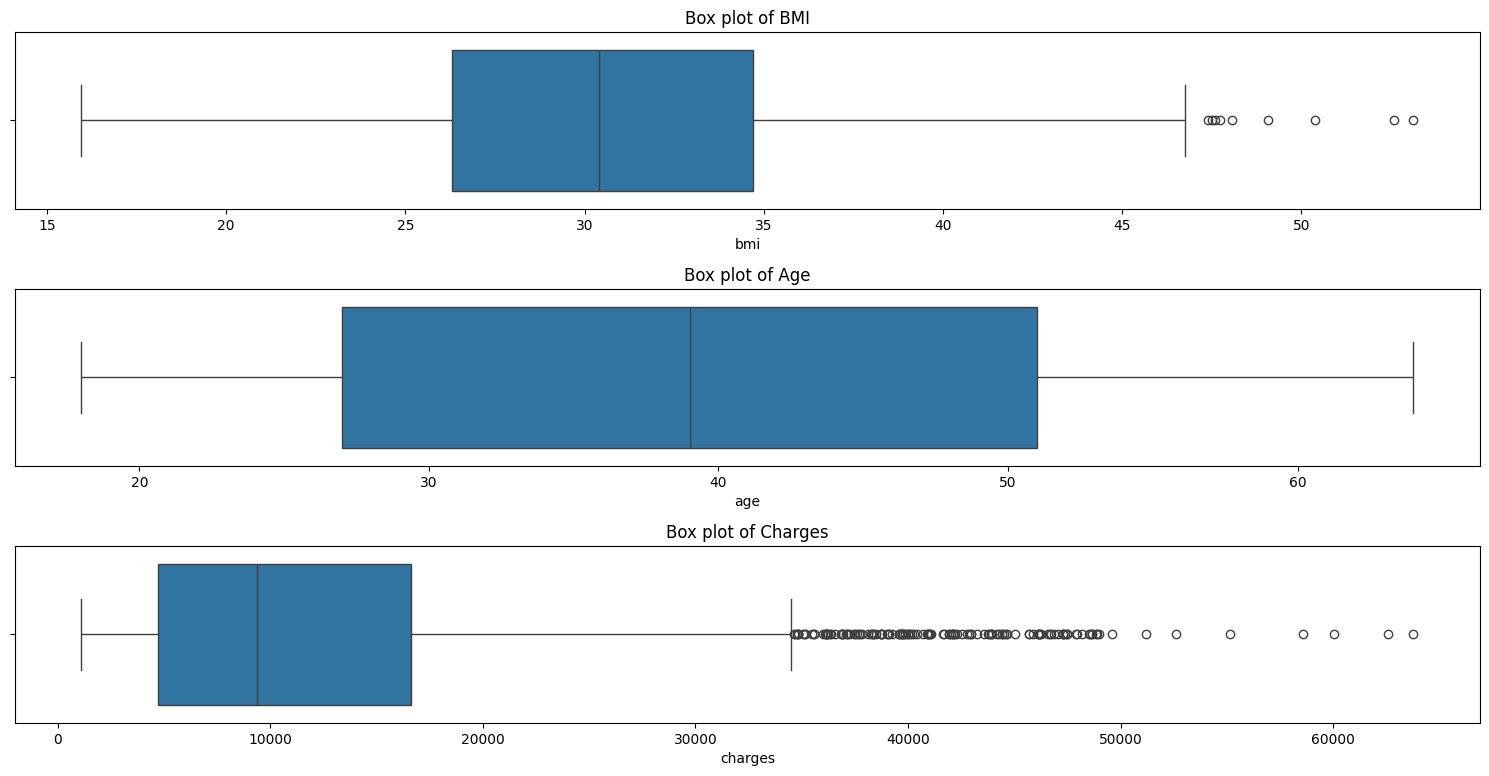

In [200]:
plt.figure(figsize=(15,10))

plt.subplot(4,1,1)
sns.boxplot(x = df_encoded['bmi'])
plt.title('Box plot of BMI')

plt.subplot(4,1,2)
sns.boxplot(x = df_encoded['age'])
plt.title('Box plot of Age')

plt.subplot(4,1,3)
sns.boxplot(x = df_encoded['charges'])
plt.title('Box plot of Charges')

plt.tight_layout()
plt.show()


#### Removing the outliers

In [201]:
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df


Calling the remove outlier function

In [202]:
df_cleaned = remove_outliers(df_encoded, ['charges', 'bmi'])

#### Plotting the boxplots again

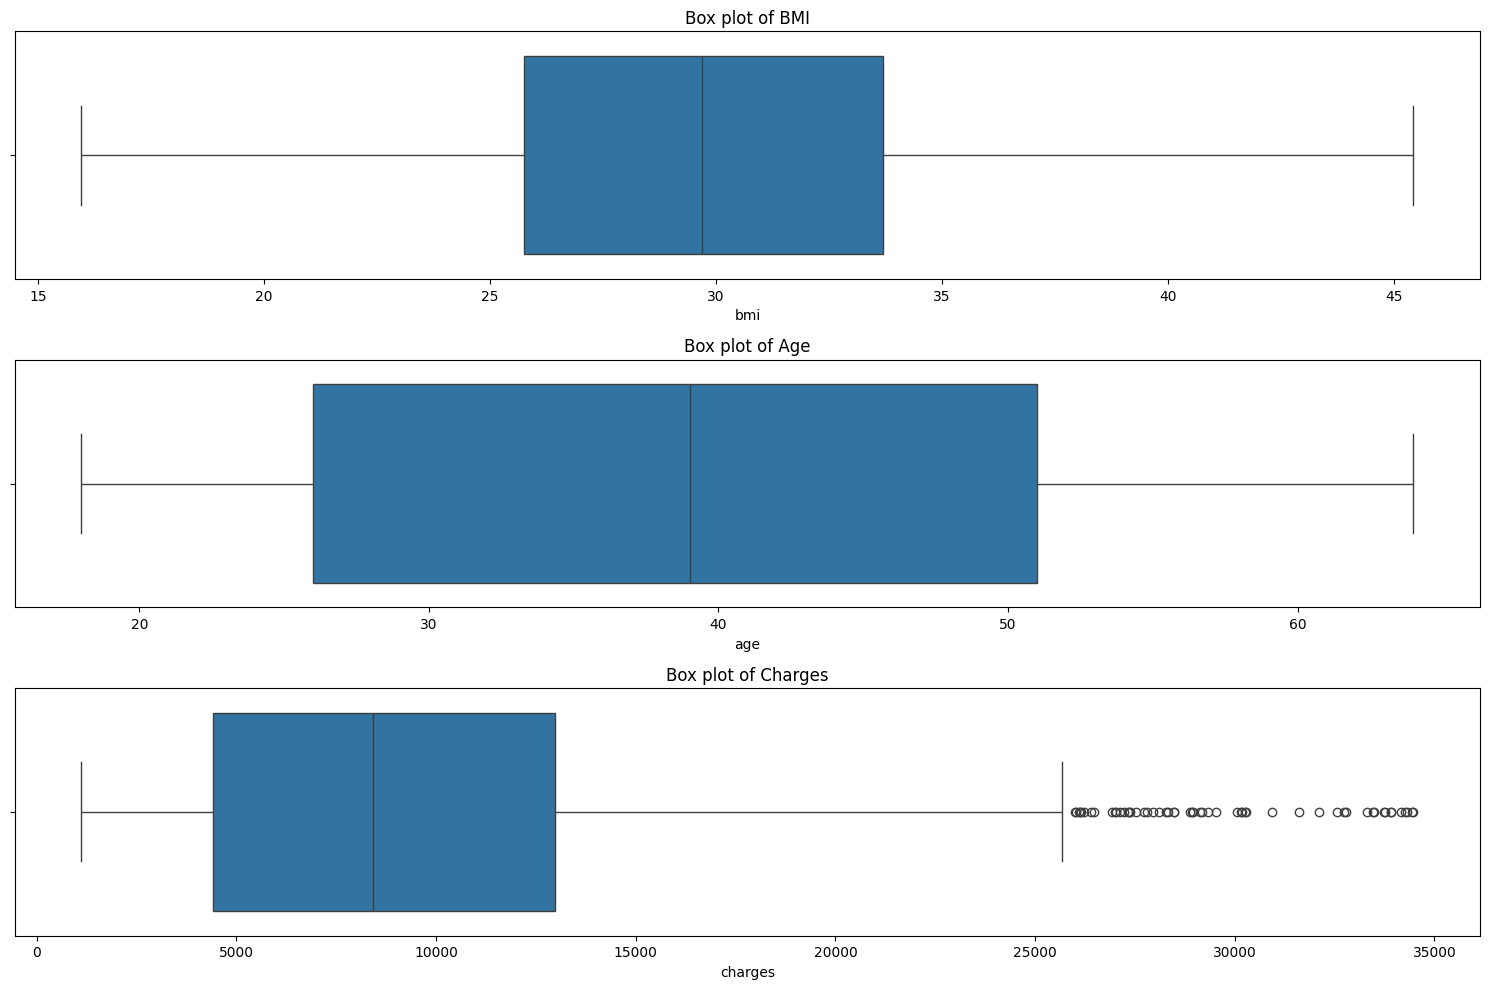

In [203]:
plt.figure(figsize=(15,10))

plt.subplot(3,1,1)
sns.boxplot(x = df_cleaned['bmi'])
plt.title('Box plot of BMI')

plt.subplot(3,1,2)
sns.boxplot(x = df_cleaned['age'])
plt.title('Box plot of Age')

plt.subplot(3,1,3)
sns.boxplot(x = df_cleaned['charges'])
plt.title('Box plot of Charges')

plt.tight_layout()
plt.show()


There are still outliers but the really big ones are removed

## Plotting data

Distribution plots


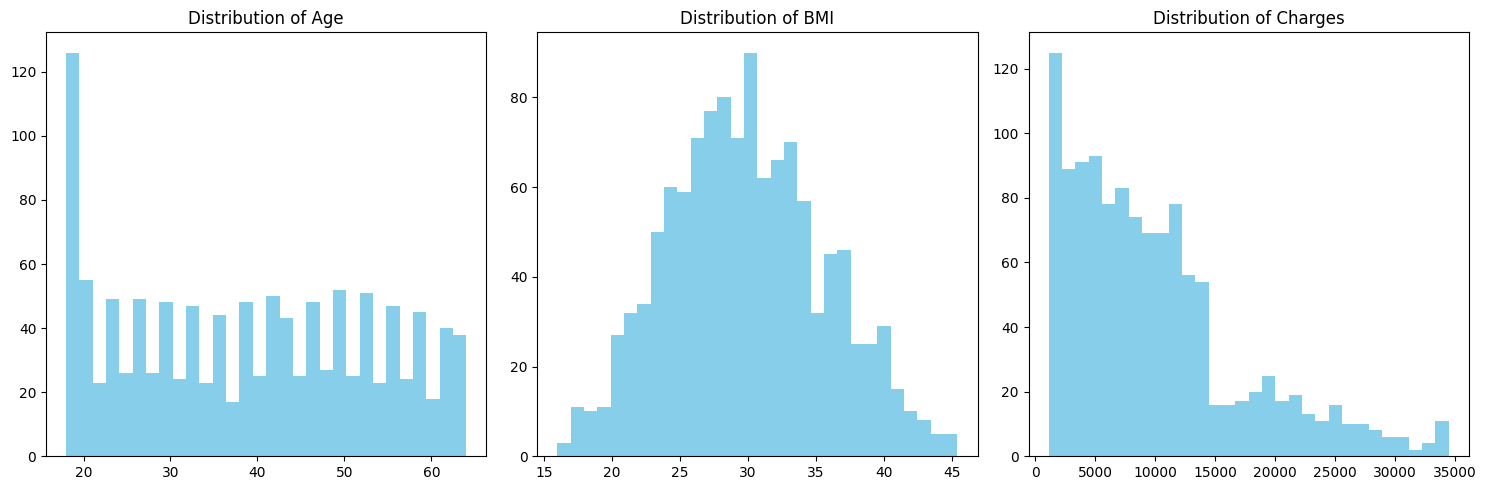

In [234]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.hist(df_cleaned['age'], bins=30, color='skyblue')
plt.title('Distribution of Age')

plt.subplot(1,3,2)
plt.hist(df_cleaned['bmi'], bins=30, color='skyblue')
plt.title('Distribution of BMI')

plt.subplot(1,3,3)
plt.hist(df_cleaned['charges'], bins=30, color='skyblue')
plt.title('Distribution of Charges')

plt.tight_layout()
plt.show()


##### Scatterplots

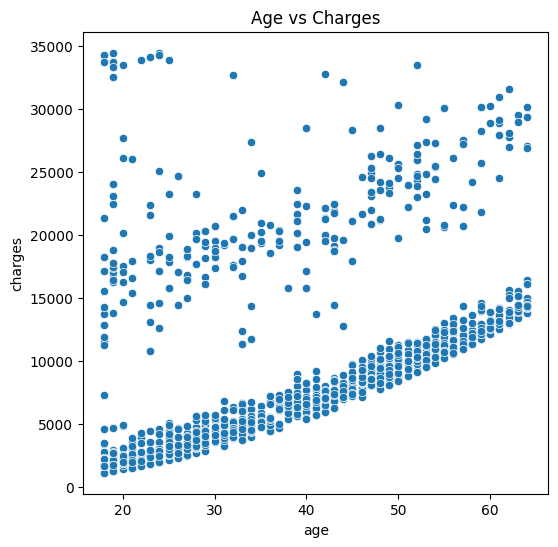

In [205]:
plt.figure(figsize=(6,6))
sns.scatterplot(x='age', y='charges', data=df_cleaned)
plt.title('Age vs Charges')
plt.show()


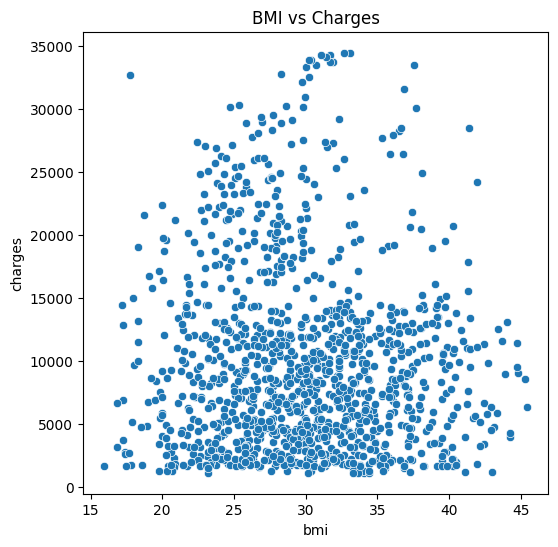

In [206]:
plt.figure(figsize=(6,6))
sns.scatterplot(x='bmi', y='charges', data=df_cleaned)
plt.title('BMI vs Charges')
plt.show()


#### Compare to charges for smokers

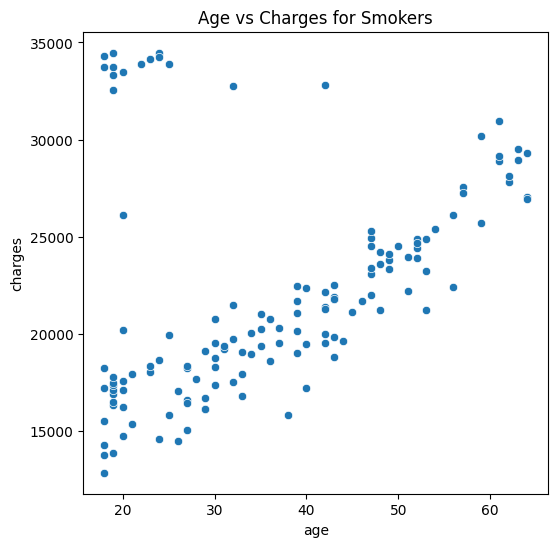

In [212]:
plt.figure(figsize=(6,6))
sns.scatterplot(x='age', y='charges', data=df_cleaned[df_cleaned['smoker_yes'] == 1])
plt.title('Age vs Charges for Smokers')
plt.show()

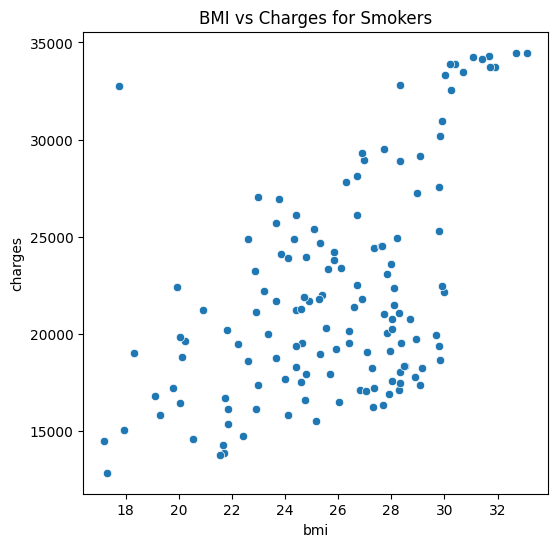

In [213]:
plt.figure(figsize=(6,6))
sns.scatterplot(x='bmi', y='charges', data=df_cleaned[df_cleaned['smoker_yes'] == 1])
plt.title('BMI vs Charges for Smokers')
plt.show()

It is interesting to see that there are clearer differences when compared with charges vs smokers

## Plot chargers for smokers vs non smokers

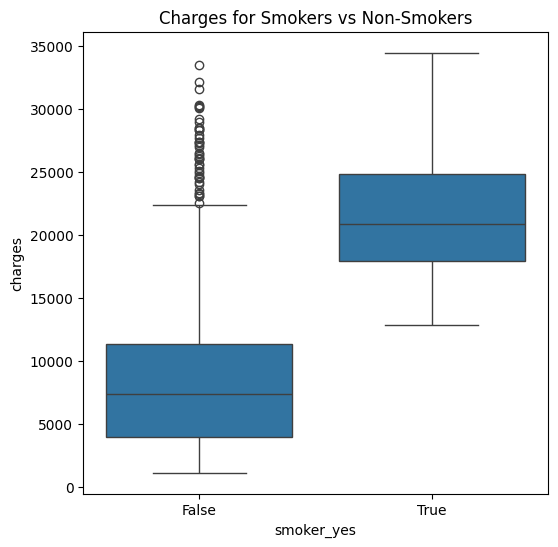

In [214]:
plt.figure(figsize=(6,6))
sns.boxplot(x='smoker_yes', y='charges', data=df_cleaned)
plt.title('Charges for Smokers vs Non-Smokers')
plt.show()


## Splitting the data

In [215]:
# Define your features and target
X = df_cleaned.drop('charges', axis=1)
y = df_cleaned['charges']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))


Training set size: 948
Test set size: 238


## Training models

In [216]:
# Train a Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Train a Decision Tree model
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


Linear Regression RMSE:  5211.737935968499
Decision Tree RMSE:  6320.128384157805
Random Forest RMSE:  5179.77784502396


## Print the results

In [220]:
# Linear Regression metrics
print("Linear Regression RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("Linear Regression R^2: ", r2_score(y_test, y_pred_lr))
print("Linear Regression MAE: ", mean_absolute_error(y_test, y_pred_lr))
print("")

# Decision Tree metrics
print("Decision Tree RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_dt)))
print("Decision Tree R^2: ", r2_score(y_test, y_pred_dt))
print("Decision Tree MAE: ", mean_absolute_error(y_test, y_pred_dt))
print("")

# Random Forest metrics
print("Random Forest RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest R^2: ", r2_score(y_test, y_pred_rf))
print("Random Forest MAE: ", mean_absolute_error(y_test, y_pred_rf))


Linear Regression RMSE:  5211.737935968499
Linear Regression R^2:  0.5146732062201456
Linear Regression MAE:  2963.74188196293

Decision Tree RMSE:  6320.128384157805
Decision Tree R^2:  0.2862914003880489
Decision Tree MAE:  3035.9881468487397

Random Forest RMSE:  5179.77784502396
Random Forest R^2:  0.5206073222901778
Random Forest MAE:  2818.443927693634


#### Plotting the results


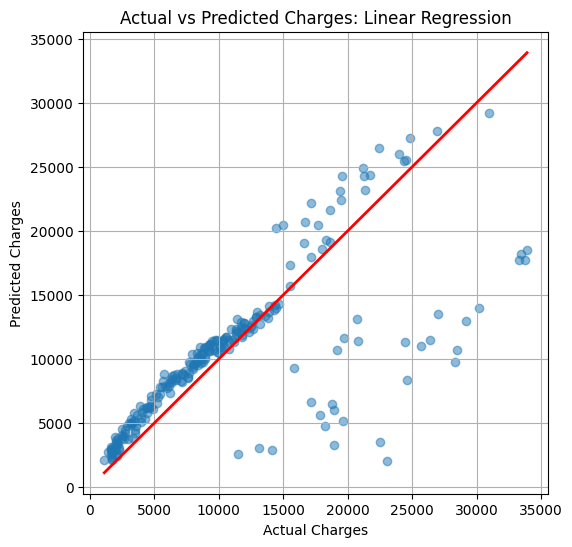

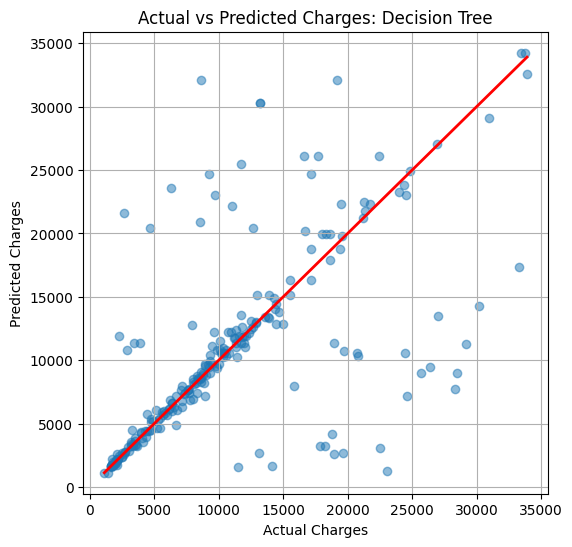

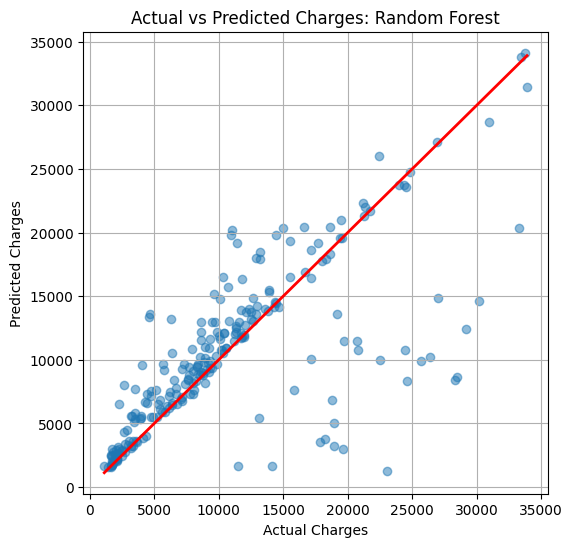

In [246]:
# Plot for Linear Regression Model
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.plot(np.linspace(min(y_test), max(y_test), 100), np.linspace(min(y_test), max(y_test), 100), color='red', linewidth=2)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges: Linear Regression')
plt.grid(True)
plt.show()

# Plot for Decision Tree Model
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_dt, alpha=0.5)
plt.plot(np.linspace(min(y_test), max(y_test), 100), np.linspace(min(y_test), max(y_test), 100), color='red', linewidth=2)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges: Decision Tree')
plt.grid(True)
plt.show()

# Plot for Random Forest Model
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot(np.linspace(min(y_test), max(y_test), 100), np.linspace(min(y_test), max(y_test), 100), color='red', linewidth=2)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges: Random Forest')
plt.grid(True)
plt.show()


## Feature importance

In [221]:
# Feature importance for Random Forest
importance = pd.DataFrame({'feature': X_train.columns, 'importance': rf.feature_importances_})
importance = importance.sort_values('importance', ascending=False)
print(importance)


             feature  importance
0                age    0.343072
3          smoker_no    0.204459
1                bmi    0.169039
4         smoker_yes    0.166090
2           children    0.049116
7   region_northeast    0.014256
8   region_northwest    0.013527
9   region_southeast    0.013052
5         sex_female    0.009895
6           sex_male    0.009816
10  region_southwest    0.007677


## HyperParameter tuning
#### From here on out we will use the model RandomForest


In [222]:

param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", np.sqrt(-grid_search.best_score_))


Best parameters:  {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best score:  4333.21046757267


#### Training the optimized model and plotting it next to the normal model

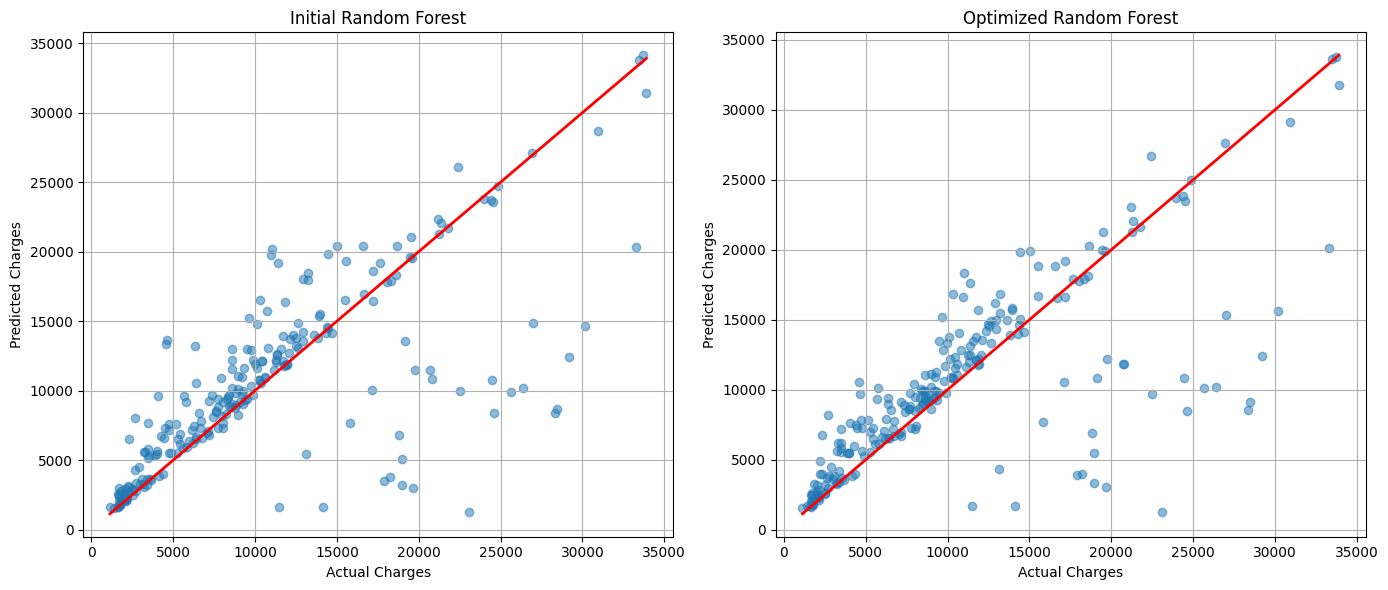

In [248]:
# Train a new Random Forest model with the best parameters
best_params = grid_search.best_params_
rf_best = RandomForestRegressor(n_estimators=best_params['n_estimators'], 
                                max_depth=best_params['max_depth'], 
                                min_samples_split=best_params['min_samples_split'], 
                                random_state=42)
rf_best.fit(X_train, y_train)

# Make predictions with the new model
y_pred_best = rf_best.predict(X_test)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot for initial Random Forest Model
axs[0].scatter(y_test, y_pred_rf, alpha=0.5)
axs[0].plot(np.linspace(min(y_test), max(y_test), 100), np.linspace(min(y_test), max(y_test), 100), color='red', linewidth=2)
axs[0].set_xlabel('Actual Charges')
axs[0].set_ylabel('Predicted Charges')
axs[0].set_title('Initial Random Forest')
axs[0].grid(True)

# Plot for optimized Random Forest Model
axs[1].scatter(y_test, y_pred_best, alpha=0.5)
axs[1].plot(np.linspace(min(y_test), max(y_test), 100), np.linspace(min(y_test), max(y_test), 100), color='red', linewidth=2)
axs[1].set_xlabel('Actual Charges')
axs[1].set_ylabel('Predicted Charges')
axs[1].set_title('Optimized Random Forest')
axs[1].grid(True)

plt.tight_layout()
plt.show()


AS you can see the optimized random forest is not much better or equally good as the normal random forest.

## Cross validation

In [223]:
scores = cross_val_score(rf, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
rf_scores = np.sqrt(-scores)

print("Scores: ", rf_scores)
print("Mean: ", rf_scores.mean())
print("Standard deviation: ", rf_scores.std())


Scores:  [5151.72260828 3785.86158267 4683.43926759 4796.3136672  4636.16813692
 4701.66736346 3538.40483019 3537.56292887 4525.20889896 4996.46894019]
Mean:  4435.281822433798
Standard deviation:  563.1680155230126


## Test / Predict with new data

In [244]:
# Get the list of column names from the training data
column_names = X_train.columns.tolist()

# Create a new data point
new_data = pd.DataFrame({
    'age': [19],
    'sex_male': [1],
    'sex_female': [0],
    'bmi': [24.3],
    'children': [0],
    'smoker_yes': [0],
    'smoker_no': [1],
    'region_northeast': [0],
    'region_northwest': [1],
    'region_southeast': [0],
    'region_southwest': [0]
}, columns=column_names)

# Make a prediction
new_data_prediction = rf.predict(new_data)

print("Predicted charge: ", new_data_prediction[0])


Predicted charge:  1639.429913000002
